Rawan Hassan Abu Alkhayr - 4111751

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np

Train Epoch: 1, Loss: 0.008876, Accuracy: 79.42%
Test set: Average loss: 0.0004, Accuracy: 8545/10000 (85.45%)
Train Epoch: 2, Loss: 0.006189, Accuracy: 85.63%
Test set: Average loss: 0.0003, Accuracy: 8778/10000 (87.78%)
Train Epoch: 3, Loss: 0.005414, Accuracy: 87.44%
Test set: Average loss: 0.0003, Accuracy: 8884/10000 (88.84%)
Train Epoch: 4, Loss: 0.005029, Accuracy: 88.25%
Test set: Average loss: 0.0003, Accuracy: 8943/10000 (89.43%)
Train Epoch: 5, Loss: 0.004680, Accuracy: 89.03%
Test set: Average loss: 0.0003, Accuracy: 8966/10000 (89.66%)
Train Epoch: 6, Loss: 0.004181, Accuracy: 90.16%
Test set: Average loss: 0.0003, Accuracy: 9028/10000 (90.28%)
Train Epoch: 7, Loss: 0.003989, Accuracy: 90.70%
Test set: Average loss: 0.0003, Accuracy: 9037/10000 (90.37%)
Train Epoch: 8, Loss: 0.003920, Accuracy: 90.79%
Test set: Average loss: 0.0003, Accuracy: 9047/10000 (90.47%)
Train Epoch: 9, Loss: 0.003903, Accuracy: 90.90%
Test set: Average loss: 0.0003, Accuracy: 9068/10000 (90.68%)
T

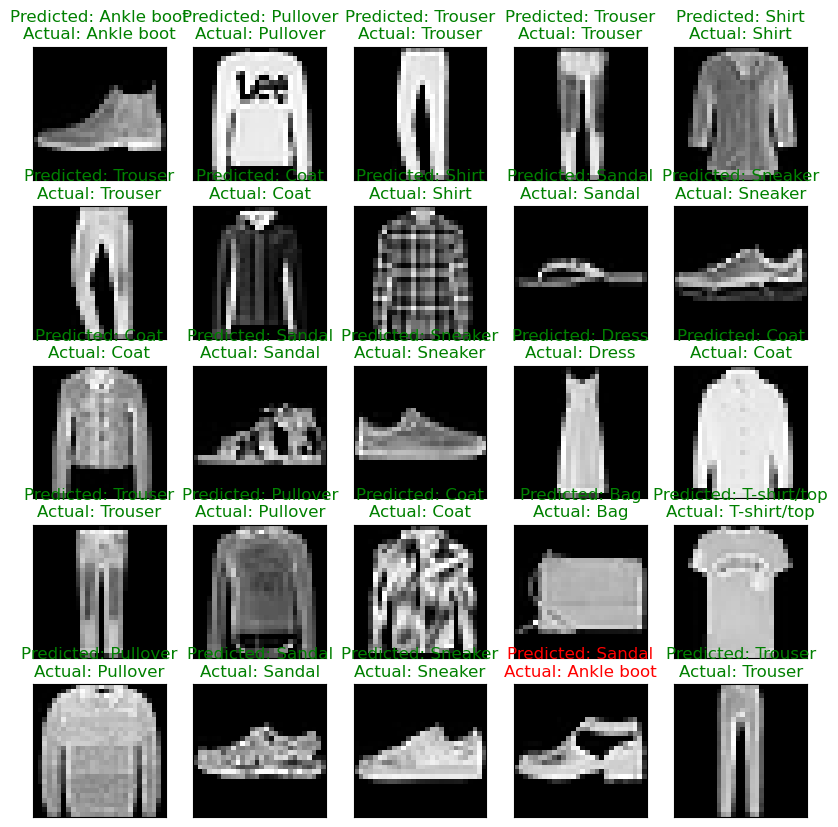

In [8]:
# Define FashionNet model architecture 
class FashionNet(nn.Module):
    def __init__(self):
        super(FashionNet, self).__init__() # Call the constructor of the parent class
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # First convolutional layer with 1 input channel, 32 output channels, 3x3 kernel size, and stride 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  # Second convolutional layer with 32 input channels, 64 output channels, 3x3 kernel size, and stride 1
        # Fully connected layers
        self.fc1 = nn.Linear(64*5*5, 128) # First fully connected layer with 64x5x5 input features and 128 output features
        self.fc2 = nn.Linear(128, 10) # Second fully connected layer with 128 input features and 10 output features (for 10 classes)
        # Dropout layers to prevent overfitting
        self.dropout1 = nn.Dropout2d(0.25) # Dropout layer with dropout probability of 0.25
        self.dropout2 = nn.Dropout2d(0.5) # Dropout layer with dropout probability of 0.5
    # Forward pass through the network
    def forward(self, x):
        x = self.conv1(x)  # Pass input through the first convolutional layer
        x = F.relu(x) # Apply ReLU activation function
        x = F.max_pool2d(x, 2)  # Perform max pooling operation with 2x2 kernel size
        x = self.dropout1(x) # Apply dropout
        x = self.conv2(x) # Pass input through the second convolutional layer
        x = F.relu(x) # Apply ReLU activation function
        x = F.max_pool2d(x, 2) # Perform max pooling operation with 2x2 kernel size
        x = self.dropout2(x) # Apply dropout
        x = torch.flatten(x, 1)  # Flatten the input tensor
        x = self.fc1(x)  # Pass flattened input through the first fully connected layer
        x = F.relu(x) # Apply ReLU activation function
        x = self.fc2(x)  # Pass output of first FC layer through the second fully connected layer
        output = F.log_softmax(x, dim=1)  # Apply log softmax activation to get class probabilities
        return output

# Load Fashion-MNIST dataset and apply transformations
transform = transforms.Compose([
    transforms.ToTensor(), # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize tensor with mean and standard deviation
])

# Load Fashion-MNIST training and test datasets
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)  # Load training dataset
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform) # Load test dataset

# Create DataLoader objects for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # Create DataLoader for training dataset
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False) # Create DataLoader for test dataset

# Initialize model, optimizer, loss function, and learning rate scheduler
model = FashionNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Check if GPU is available, otherwise use CPU
model.to(device) # Move model to GPU if available
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with learning rate of 0.001
scheduler = StepLR(optimizer, step_size=5, gamma=0.1) # Learning rate scheduler
criterion = nn.NLLLoss() # Negative log likelihood loss for classification

# Define training function
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()  # Set the model to training mode
    train_loss = 0  # Initialize training loss
    correct = 0  # Initialize number of correct predictions
    for batch_idx, (data, target) in enumerate(train_loader):  # Iterate over batches in the training DataLoader
        data, target = data.to(device), target.to(device)  # Move data and target tensors to the device (GPU if available)
        optimizer.zero_grad()  # Clear the gradients from previous iterations
        output = model(data)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(output, target)  # Calculate the batch loss
        train_loss += loss.item()  # Accumulate the training loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()  # Count the number of correct predictions in the batch
    
    train_loss /= len(train_loader.dataset)  # Compute the average training loss over the dataset
    accuracy = 100. * correct / len(train_loader.dataset)  # Compute the training accuracy
    print(f'Train Epoch: {epoch}, Loss: {train_loss:.6f}, Accuracy: {accuracy:.2f}%')  # Print training loss and accuracy

# Testing function
def test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0  # Initialize test loss
    correct = 0  # Initialize number of correct predictions
    with torch.no_grad():  # Disable gradient calculation during inference
        for data, target in test_loader:  # Iterate over batches in the test DataLoader
            data, target = data.to(device), target.to(device)  # Move data and target tensors to the device
            output = model(data)  # Forward pass: compute predicted outputs by passing inputs to the model
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()  # Count the number of correct predictions
    
    test_loss /= len(test_loader.dataset)  # Compute the average test loss over the dataset
    accuracy = 100. * correct / len(test_loader.dataset)  # Compute the test accuracy
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')  # Print test loss and accuracy

# Visualize function
def visualize(model, device, test_loader, classes):
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images) # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(output, 1)

            # Plot the images and their predicted labels
            fig = plt.figure(figsize=(10, 10))
            for idx in np.arange(25):  # Visualize 25 images from the batch
                ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
                ax.imshow(np.squeeze(images[idx].cpu()), cmap='gray')
                ax.set_title("Predicted: {}\nActual: {}".format(classes[predicted[idx]], classes[labels[idx]]),
                             color=("green" if predicted[idx]==labels[idx] else "red"))
            plt.show()
            break  # Stop after the first batch for visualization


# Training loop
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader, criterion)
    scheduler.step()

# Visualize predictions
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
visualize(model, device, test_loader, classes)


CNN Architecture:

The model implements a CNN with two convolutional layers (nn.Conv2d) followed by ReLU activations (F.relu).
Max pooling (nn.MaxPool2d) is applied after each convolutional layer.
Dropout layers (nn.Dropout2d) are added after max pooling to reduce overfitting, with dropout rates of 0.25 and 0.5 after the first and second convolutional layers, respectively.
Two fully connected layers (nn.Linear) are included at the end for classification. The first linear layer transforms the feature map into a vector, and the second layer outputs class probabilities for each of the 10 categories.
Log softmax (F.log_softmax) is used on the output of the last layer to compute the probabilities.

GPU Compatibility:

The model is initialized with torch.device("cuda" if torch.cuda.is_available() else "cpu"), which ensures that it can be deployed on a GPU if available ("cuda") or on the CPU ("cpu"). This allows for faster training on GPU when available.

Loss Function:
Cross-entropy loss is employed during training using nn.NLLLoss() (negative log likelihood loss) as the loss function.

Optimizer:
The Adam optimizer (optim.Adam) is used to adjust the weights of the neural network during training. This is achieved with optimizer = optim.Adam(model.parameters(), lr=0.001).

Training Epochs:
The model is trained for a suitable number of epochs, which is set to 10 in the provided code. This is evident from the training loop: for epoch in range(1, epochs + 1):.

Printing Training Loss and Accuracy:
After each epoch, the code prints the training loss and accuracy using the train() function. For example:
 
Train Epoch: 1, Loss: 0.008819, Accuracy: 79.46%

Learning Rate Scheduler:
A learning rate scheduler (StepLR) is included to adjust the learning rate during training. This is achieved with scheduler = StepLR(optimizer, step_size=5, gamma=0.1).

Based on the provided results, here's an explanation of the obtained accuracy and the key differences between MNIST and Fashion-MNIST:

1. **Accuracy Trends**: 
   - The training accuracy steadily increases from around 79.42% in the first epoch to approximately 91.01% in the tenth epoch.
   - Similarly, the test accuracy shows a consistent improvement, starting from 85.45% in the first epoch to 90.61% in the tenth epoch.
   - This trend indicates that the model is learning and generalizing well over epochs.

2. **Key Differences between MNIST and Fashion-MNIST**:
   - **Dataset Complexity**: Fashion-MNIST dataset is more complex compared to MNIST as it contains grayscale images of fashion items like clothes, shoes, and accessories, whereas MNIST contains grayscale images of handwritten digits.
   - **Number of Classes**: MNIST has 10 classes (digits 0 through 9), while Fashion-MNIST has 10 classes representing different fashion items (e.g., T-shirt/top, Trouser, Pullover, etc.).
   - **Image Complexity**: Fashion-MNIST images are more diverse and intricate compared to MNIST images which are simpler handwritten digits.
   - **Classification Challenge**: Due to the greater diversity and complexity of Fashion-MNIST images, classifying them correctly is generally considered a more challenging task compared to MNIST.
   - **Generalization**: Achieving high accuracy on Fashion-MNIST indicates a model's ability to generalize well to diverse and complex image datasets, which is a key requirement for real-world applications.
   - **Model Complexity**: Models trained on Fashion-MNIST may require more complex architectures and longer training times compared to MNIST due to the increased complexity of the dataset.

Overall, the achieved accuracy on Fashion-MNIST demonstrates the effectiveness of the model in learning and generalizing from a more complex and diverse dataset compared to MNIST.